<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/BOW_LR/TwitterDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import torch
import pandas as pd
import re
import os
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import kagglehub

In [ ]:

path = kagglehub.dataset_download("sudishbasnet/truthseekertwitterdataset2023")
dataset_dir = "/root/.cache/kagglehub/datasets/sudishbasnet/truthseekertwitterdataset2023/"

# Dynamically locate CSV
file_name = None
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if "Truth_Seeker_Model_Dataset" in file and file.endswith(".csv"):
            file_name = os.path.join(root, file)
            break

# Load the dataset
df = pd.read_csv(file_name)

print("Dataset preview:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())

# missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)
df.dropna(subset=['tweet', 'BinaryNumTarget'], inplace=True)

# Rename columns
df.rename(columns={'tweet': 'text', 'BinaryNumTarget': 'label'}, inplace=True)

# Filter the data
filtered_texts = []
filtered_labels = []
for text, label in zip(df['text'], df['label']):
    if len(text) > 50 and text not in filtered_texts:
        filtered_texts.append(text)
        filtered_labels.append(label)

# Create a new filtered DataFrame
filtered_df = pd.DataFrame({'text': filtered_texts, 'label': filtered_labels})


Dataset preview:
   Unnamed: 0      author                                          statement  \
0           0  D.L. Davis  End of eviction moratorium means millions of A...   
1           1  D.L. Davis  End of eviction moratorium means millions of A...   
2           2  D.L. Davis  End of eviction moratorium means millions of A...   
3           3  D.L. Davis  End of eviction moratorium means millions of A...   
4           4  D.L. Davis  End of eviction moratorium means millions of A...   

   target  BinaryNumTarget                 manual_keywords  \
0    True              1.0  Americans, eviction moratorium   
1    True              1.0  Americans, eviction moratorium   
2    True              1.0  Americans, eviction moratorium   
3    True              1.0  Americans, eviction moratorium   
4    True              1.0  Americans, eviction moratorium   

                                               tweet 5_label_majority_answer  \
0  @POTUS Biden Blunders - 6 Month Update\n\nInfl

In [ ]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

# Apply text preprocessing
filtered_df['processed_text'] = filtered_df['text'].apply(preprocess_text)

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    filtered_df['processed_text'], filtered_df['label'], test_size=0.2, random_state=42
)


Model Accuracy: 0.97
Unique classes in test labels: [0.0, 1.0]

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.97      0.97     12930
        True       0.97      0.97      0.97     13713

    accuracy                           0.97     26643
   macro avg       0.97      0.97      0.97     26643
weighted avg       0.97      0.97      0.97     26643



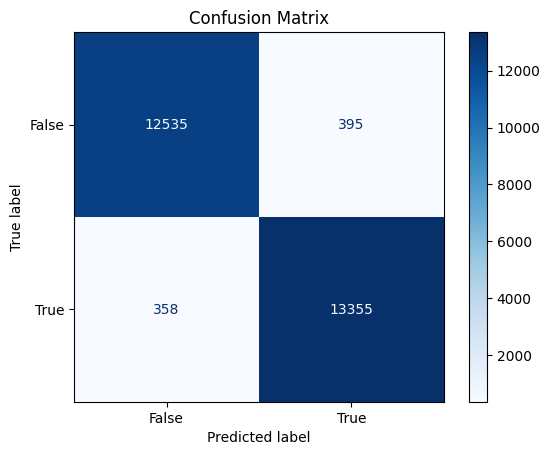


Sample Predictions:

Sample 1
Text: dr fauci in 2005 said 
hydroxychloroquine is a wonder drug for coronavirus it functions as both a cure amp a vaccine

the origin of covid19

why are board members of vaccine companies also fda commissioners
Predicted: False, Actual: False

Sample 2
Text: independent_ie a young woman i know well in her late 20s developed scarring on her lungs and a heart condition a few days after her mrna vaccine and can no longer work these vaccines are experimental gene therapy and req much longer trials but were rushed throappalling for those affected
Predicted: False, Actual: False

Sample 3
Text: kamalaharris joebiden appears jacob blake had a weapon  a knife would not drop it when asked was tazed but failed to immobilize him said he had a gun in his car and tried to reach for itthere is a condition called suicide by copmaybe let the investigation play out before burning down shit
Predicted: False, Actual: False

Sample 4
Text: beware stop using the abbreviatio

In [ ]:
# Tfidf
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# Model Training with Logistic Regression
model = LogisticRegression(max_iter=200, solver='saga', penalty='l2', C=1.0)
model.fit(X_train, train_labels)

# Predict on the test set
predictions = model.predict(X_test)

accuracy = accuracy_score(test_labels, predictions)
print(f"\nModel Accuracy: {accuracy:.2f}")

# single-class case
unique_classes = sorted(test_labels.unique())
print("Unique classes in test labels:", unique_classes)

target_names = ['False', 'True'][:len(unique_classes)]

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, predictions, labels=unique_classes, target_names=target_names))

# Confusion Matrix
if len(unique_classes) > 1:
    conf_matrix = confusion_matrix(test_labels, predictions)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=target_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("\nConfusion Matrix not displayed due to single class in the test set.")

# Display a few predictions
print("\nSample Predictions:")
for i, (text, pred, true_label) in enumerate(zip(test_texts[:5], predictions[:5], test_labels[:5])):
    print(f"\nSample {i+1}")
    print(f"Text: {text}")
    print(f"Predicted: {'True' if pred else 'False'}, Actual: {'True' if true_label else 'False'}")